# Implementing LangGraph and Checking LLMs

Installing the necessary imports

In [3]:
NEW_ENV = False

if NEW_ENV:
    %pip install --quiet langchain langchain-community langchain-openai langgraph sqlglot

import os
import getpass
import pandas as pd
import sqlite3
from IPython.display import Image, display
import sqlglot
from operator import itemgetter
import pprint
pp = pprint.PrettyPrinter(indent=4)


from langchain_core.runnables import RunnablePassthrough
from langchain_community.utilities import SQLDatabase
from langchain_openai import ChatOpenAI
from langchain.chains import create_sql_query_chain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.prompts import PromptTemplate

os.environ["OPENAI_API_KEY"] = getpass.getpass("OPENAI_API_KEY")

Note: you may need to restart the kernel to use updated packages.


OPENAI_API_KEY ·······························································································


Creating a SQLite connection to the Chinook DB

In [4]:
con = sqlite3.connect("/kaggle/input/chinook/Chinook_Sqlite.sqlite")
cursor = con.cursor()
cursor.close()

# connect to database
db = SQLDatabase.from_uri("sqlite:////kaggle/input/chinook/Chinook_Sqlite.sqlite")

# test connection
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


Setting up OpenAI connection and utilize premade SQL chain

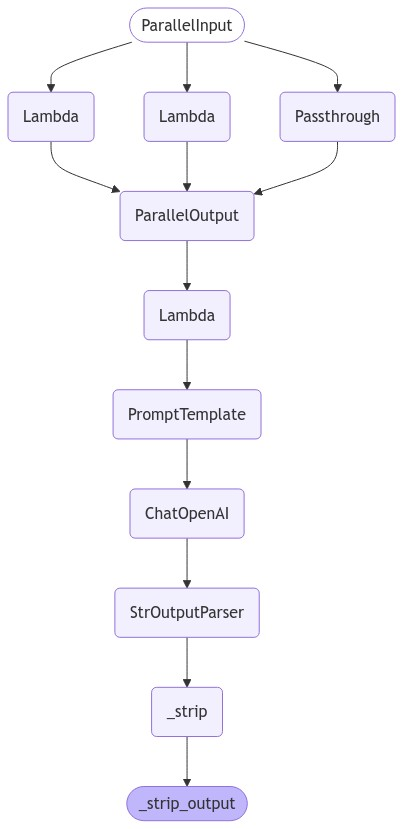

In [5]:
# create API connection to OpenAI chat model
llm = ChatOpenAI(model="gpt-4o-mini")

# use a pre-made chain for generating SQL queries with an LLM
write_query = create_sql_query_chain(llm, db)

# visualize chain
display(Image(write_query.get_graph().draw_mermaid_png()))

Testing SQL LangChain

In [6]:
query_missing_fax = write_query.invoke(
    {
        "question": "What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010"
    }
)

print("Question: What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010")
print("Result: ")
print(query_missing_fax)

query_n_employees = write_query.invoke(
    {
        "question": "How many employees are there?"
    }
)

print('\n')
print("Question: How many employees are there?")
print("Result: ")
print(query_n_employees)

Question: What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010
Result: 
```sql
SELECT AVG("Total") AS "AverageInvoice"
FROM "Invoice" 
JOIN "Customer" ON "Invoice"."CustomerId" = "Customer"."CustomerId"
WHERE "Customer"."Country" = 'USA'
AND "Customer"."Fax" IS NULL
AND "Invoice"."InvoiceDate" >= '2003-01-01' 
AND "Invoice"."InvoiceDate" < '2010-01-01';
```


Question: How many employees are there?
Result: 
SQLQuery: SELECT COUNT("EmployeeId") AS "EmployeeCount" FROM "Employee";


##### Implement LLM based checking

In [7]:
llm_check_system_prompt = """Double check the user's {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins
- Remove any LLM decorators such as ```sql and ```

If there are any of the above mistakes, rewrite the query.
If there are no mistakes, just reproduce the original query with no further commentary.

Output the final SQL query only."""

prompt = ChatPromptTemplate.from_messages(
    [("system", llm_check_system_prompt), ("human", "{query}")]
).partial(dialect=db.dialect)

validation_chain = prompt | llm | StrOutputParser()

chain_w_llm_check = {"query": write_query} | validation_chain

Testing chain with LLM based checking

In [8]:
query_missing_fax = chain_w_llm_check.invoke(
    {
        "question": "What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010"
    }
)

print("Question: What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010")
print("Result: ")
print(query_missing_fax)

query_n_employees = chain_w_llm_check.invoke(
    {
        "question": "How many employees are there?"
    }
)

print('\n')
print("Question: How many employees are there?")
print("Result: ")
print(query_n_employees)

Question: What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010
Result: 
SELECT AVG("Total") AS "AverageInvoice"
FROM "Invoice" 
JOIN "Customer" ON "Invoice"."CustomerId" = "Customer"."CustomerId"
WHERE "Customer"."Country" = 'USA' 
AND "Customer"."Fax" IS NULL 
AND "Invoice"."InvoiceDate" >= '2003-01-01' 
AND "Invoice"."InvoiceDate" < '2010-01-01';


Question: How many employees are there?
Result: 
SELECT COUNT("EmployeeId") AS "EmployeeCount" FROM "Employee";


##### Implement computer based checking

In [9]:
# a function to validate sql syntax using sqlglot
def parse_sql(query: str) -> dict[str, str]:
    try:
        sqlglot.transpile(query) #if this executes with no errors, the syntax is correct 
        return {"query": query, "err" : "No error. SQL parsing successful."}
    except BaseException as e:
        # return the original query and the error message
        return {"query": query, "err" : e}
    
chain_w_syntax_check = chain_w_llm_check | RunnableLambda(parse_sql)

Testing our chain with computer based checking

**Add the SQL syntax checking step to the original `write_query` chain.** 

In [10]:
query_missing_fax = chain_w_syntax_check.invoke(
    {
        "question": "What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010"
    }
)

print("Question: What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010")
print("Result: ")
pp.pprint(query_missing_fax)

query_n_employees = chain_w_syntax_check.invoke(
    {
        "question": "How many employees are there?"
    }
)

print('\n')
print("Question: How many employees are there?")
print("Result: ")
pp.pprint(query_n_employees)

Question: What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010
Result: 
{   'err': 'No error. SQL parsing successful.',
    'query': 'SELECT AVG("Total") AS "AverageInvoice"\n'
             'FROM "Invoice" \n'
             'WHERE "CustomerId" IN (\n'
             '    SELECT "CustomerId"\n'
             '    FROM "Customer"\n'
             '    WHERE "Country" = \'USA\' \n'
             '      AND "Fax" IS NULL\n'
             '      AND "CustomerId" IN (\n'
             '          SELECT "CustomerId"\n'
             '          FROM "Invoice"\n'
             '          WHERE "InvoiceDate" >= \'2003-01-01\' \n'
             '            AND "InvoiceDate" < \'2010-01-01\'\n'
             '      )\n'
             ');'}


Question: How many employees are there?
Result: 
{   'err': 'No error. SQL parsing successful.',
    'query': 'SELECT COUNT(*) AS "TotalEmployees" FROM "Employee";'}


## Implement Self-Healing with LLMs

Our first check called for a revision if necessary. With a computer-based check, we'll need to make the request for a revision in a separate step. We want a revision if the query has an error, but conditional flow is outside the scope of this course, so we will handle error and non-error cases in one prompt.

In [11]:
system_prompt_healing = """Consider the following {dialect} query, original user intent, and potential error message.
If there is an error, correct the query by addressing the issues identified in the error message. Return the corrected query. 
If there is no error, return the text of the query unmodified.  

Use format: 

ORIGINAL QUERY: 

ERROR MESSAGE:

UPDATED QUERY: 
"""

user_prompt_healing = """ORIGINAL QUERY: {query}

ERROR MESSAGE: {err}

UPDATED QUERY: """

healing_prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt_healing), ("human", user_prompt_healing)]
).partial(dialect=db.dialect)


def parse_corrected_answer(output: str) -> str:
    try: 
        return output.split("UPDATED QUERY: ")[1]
    except: 
        return output

healing_prompt.pretty_print()

================================ System Message ================================

Consider the following {dialect} query, original user intent, and potential error message.
If there is an error, correct the query by addressing the issues identified in the error message. Return the corrected query. 
If there is no error, return the text of the query unmodified.  

Use format: 

ORIGINAL QUERY: 

ERROR MESSAGE:

UPDATED QUERY: 


================================ Human Message =================================

ORIGINAL QUERY: {query}

ERROR MESSAGE: {err}

UPDATED QUERY: 


In [12]:
chain_w_healing = chain_w_syntax_check | healing_prompt | llm | RunnableLambda(parse_corrected_answer)

In [13]:
query_missing_fax = chain_w_healing.invoke(
    {
        "question": "What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010"
    }
)

print("Question: What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010")
print("Result: ")
print(query_missing_fax)

query_n_employees = chain_w_healing.invoke(
    {
        "question": "How many employees are there?"
    }
)

print('\n')
print("Question: How many employees are there?")
print("Result: ")
print(query_n_employees)

Question: What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010
Result: 
content='ORIGINAL QUERY: SELECT AVG("Total") AS "AverageInvoice"\nFROM "Invoice"\nWHERE "CustomerId" IN (\n    SELECT "CustomerId"\n    FROM "Customer"\n    WHERE "Country" = \'USA\' AND "Fax" IS NULL\n) AND "InvoiceDate" >= \'2003-01-01\' AND "InvoiceDate" < \'2010-01-01\';\n\nERROR MESSAGE: No error. SQL parsing successful.\n\nUPDATED QUERY: SELECT AVG("Total") AS "AverageInvoice"\nFROM "Invoice"\nWHERE "CustomerId" IN (\n    SELECT "CustomerId"\n    FROM "Customer"\n    WHERE "Country" = \'USA\' AND "Fax" IS NULL\n) AND "InvoiceDate" >= \'2003-01-01\' AND "InvoiceDate" < \'2010-01-01\';' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 171, 'prompt_tokens': 178, 'total_tokens': 349, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_